In [1]:
import os
from importlib.resources import files
import time

import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
# from scipy.spatial.distance import cosine
# from sklearn.metrics.pairwise import cosine_similarity
from learn_embedding.utils.soft_dtw_cuda import SoftDTW
from dtaidistance import dtw_ndim

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry
from learn_embedding.utils import *
from learn_embedding.loss import *

In [2]:
dim = 2
num_traj = 7  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory
split = int(np.round(num_traj*0.6))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
data_x = []
data_y = []

for i in range(1, num_traj+1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    data[idx,:2] -= data[-1,:2]
    data[-1,2:4] = np.zeros(2)
    data[-1,-2:] = np.zeros(2)
    
    # add to datset
    data_x.append(data[idx,:2])
    data_y.append(data[idx,2:4])

In [26]:
reps = 1
num_neurons = [64]
num_layers = 2

cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
sdtw = SoftDTW(use_cuda=use_cuda, gamma=0.01)

rmse_log = torch.zeros(reps).to(device)
cos_log = torch.zeros(reps).to(device)
sdtw_log = torch.zeros(reps).to(device)
dtw_log = torch.zeros(reps).to(device)
fdtw_log = torch.zeros(reps).to(device)

for k in range(reps):
    idx = np.random.permutation(num_traj)
    
    train_x = np.empty((0, 2))
    train_y = np.empty((0, 2))
    
    for i in idx[:split]:
        train_x = np.append(train_x, data_x[i], axis=0)
        train_y = np.append(train_y, data_y[i], axis=0)
        
    train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
    train_y = torch.from_numpy(train_y).float().to(device)

    model = FirstGeometry(Embedding(FeedForward(dim, num_neurons*num_layers, 1)), torch.tensor([0,0]).to(device), SPD(dim)).to(device)
    trainer = Trainer(model, train_x, train_y)

    trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    # trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

    trainer.loss = torch.nn.MSELoss()
    # trainer.loss = torch.nn.SmoothL1Loss()

    trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=1000)
#     trainer.train()
    
    for i in idx[split:]:
        test_x = torch.from_numpy(data_x[i]).float().to(device).requires_grad_(True)
        test_y = torch.from_numpy(data_y[i]).float().to(device)
        
        x0 = test_x[0,:].unsqueeze(0)
        streamline = Integrator.first_order(dynamics=model,x0=x0,T=20.0, dt=0.01)[:,0,:]
        
        output = model(test_x).detach()
        
        rmse_log[k] += (output-test_y).square().sum().mean().sqrt()/(num_traj-split)
        cos_log[k] += (1 - cosine_similarity(output, test_y)).mean()/(num_traj-split)
        sdtw_log[k] += (sdtw(streamline[:,:2].unsqueeze(0), test_x.unsqueeze(0)) - 0.5*(sdtw(streamline[:,:2].unsqueeze(0), streamline[:,:2].unsqueeze(0)) + sdtw(test_x.unsqueeze(0), test_x.unsqueeze(0)))).detach().squeeze()/(num_traj-split)
#         dtw_log[k] += sdtw(streamline[:,:2].unsqueeze(0), test_x.unsqueeze(0)).squeeze()/test_x.shape[0]/(num_traj-split)

        series_1 = streamline[:,:2].cpu().detach().numpy()
        series_2 = test_x.cpu().detach().numpy()
        dtw_log[k] += torch.tensor(dtw_ndim.distance(series_1, series_2)/(num_traj-split)).to(device)
        fdtw_log[k] += torch.tensor(fastdtw(series_1, series_2, dist=euclidean)[0]/(num_traj-split)).to(device)
    
    print("Iter: ", k, "RMSE: ", rmse_log[k].item(), "Cosine: ", cos_log[k].item(), "SDTW: ", sdtw_log[k].item(),
         "DTW: ", dtw_log[k].item(), "FDTW: ", fdtw_log[k].item())    

3
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
5
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
0
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
Iter:  0 RMSE:  15.58135986328125 Cosine:  0.25465381145477295 SDTW:  48.857059478759766 DTW:  5.463051795959473 FDTW:  145.16209411621094


In [19]:
Iter:  0 RMSE:  0.4142860770225525 Cosine:  0.012710831128060818 SDTW:  9.33105182647705 DTW:  0.38576266169548035 FDTW:  14.339728355407715

0.0

In [18]:
fastdtw(series_1, series_2, dist=euclidean)[0]/test_x.shape[0]/(num_traj-split)

0.0

In [21]:
(sdtw(streamline[:,:2].unsqueeze(0), test_x.unsqueeze(0)) - 0.5*(sdtw(streamline[:,:2].unsqueeze(0), streamline[:,:2].unsqueeze(0)) + sdtw(test_x.unsqueeze(0), test_x.unsqueeze(0)))).detach().squeeze()/test_x.shape[0]/(num_traj-split)

SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)


tensor(0.0165, device='cuda:0')

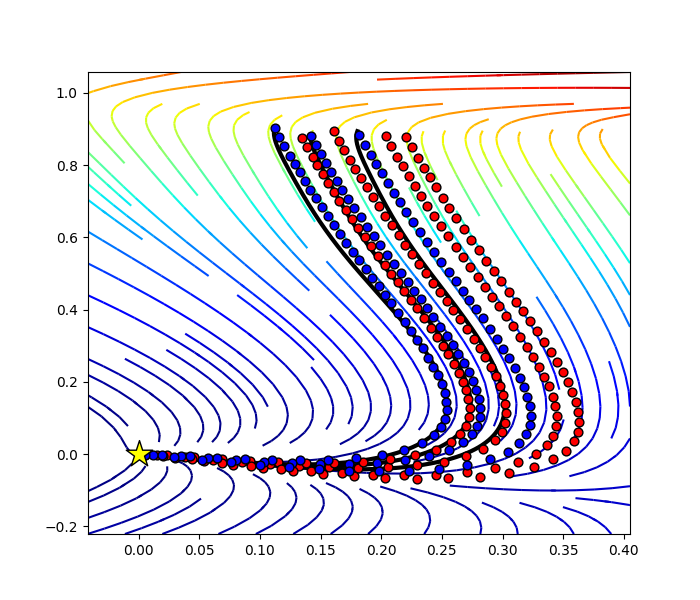

In [5]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)

potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

field = model(grid_x)
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = np.empty((0, 2))
test_x = np.empty((0, 2))
for i in idx[split:]:
    x0 = np.append(x0, data_x[i][0,:][np.newaxis, :], axis=0)
    test_x = np.append(test_x, data_x[i], axis=0)
x0 = torch.from_numpy(x0).float().to(device).requires_grad_(True)

streamlines = Integrator.first_order(dynamics=model,x0=x0,T=20.0, dt=0.01).cpu().detach().numpy()

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(test_x[::steps, 0], test_x[::steps, 1], s=40, edgecolors='k', c='blue', zorder=10)

ax.scatter(0.0, 0.0, s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=3.0)

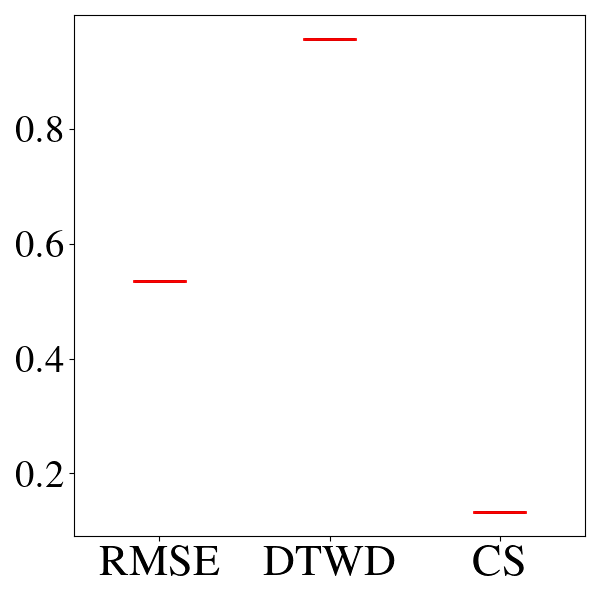

In [12]:
data = [rmse_log.cpu(), dtw_log.cpu()*100, cos_log.cpu()*10]
green_diamond = dict(markerfacecolor='g', marker='D')

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# Customize the box plot
boxprops = dict(linewidth=2, color='black', facecolor='lightgray')
medianprops = dict(linewidth=2, color='red')
whiskerprops = dict(linewidth=2, color='black')
capprops = dict(linewidth=2, color='black')
flierprops = green_diamond

boxplot = ax.boxplot(data, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops,
           capprops=capprops, flierprops=flierprops, patch_artist=True)

# Define a list of colors
colors = ['lightblue', 'lightgreen', 'lightyellow']

# Add color to the box plot elements
for patch, color in zip(boxplot['boxes'], colors):
    # Change the fill color of the boxes
    patch.set_facecolor(color)

# Customize the x-axis ticks and labels
plt.xticks([1, 2, 3], ['RMSE', 'DTWD', 'CS'], fontsize=32)
plt.yticks(fontsize=28)
# plt.xlabel('Metrics')

# Add a title and y-axis label if needed
# plt.title('Comparison of Metrics')
# plt.ylabel('Metric Values')

# Adjust the plot layout if needed
plt.tight_layout()

fig.savefig('../outputs/evaluation_learning.png', format='png', dpi=300, bbox_inches="tight")